<a href="https://colab.research.google.com/github/noahbean33/PINN_experiments/blob/main/electromagnetics_PINN_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

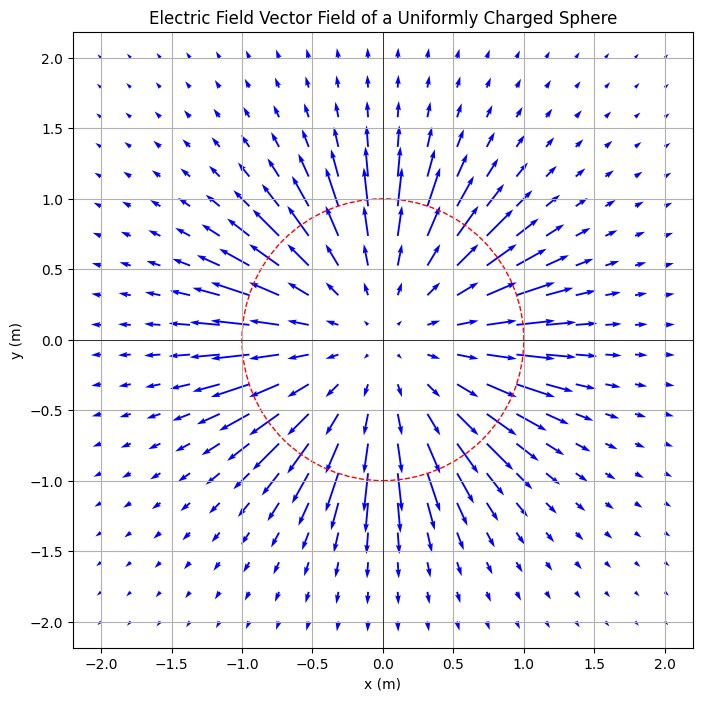

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
epsilon_0 = 8.85e-12  # Permittivity of free space (F/m)
rho = 1e-6  # Uniform charge density (C/m^3)
R = 1.0  # Radius of the sphere (m)

def electric_field_vector(x, y, rho, R, epsilon_0):
    """
    Calculate the electric field vector at a point (x, y) from the center of a uniformly charged sphere.
    """
    r = np.sqrt(x**2 + y**2)
    E = np.zeros((x.shape[0], x.shape[1], 2))

    # Inside the sphere
    inside = r < R
    E[inside, 0] = (rho * x[inside]) / (3 * epsilon_0)
    E[inside, 1] = (rho * y[inside]) / (3 * epsilon_0)

    # Outside the sphere
    outside = r >= R
    E[outside, 0] = (rho * R**3 * x[outside]) / (3 * epsilon_0 * r[outside]**3)
    E[outside, 1] = (rho * R**3 * y[outside]) / (3 * epsilon_0 * r[outside]**3)

    return E

# Define the grid for plotting
x = np.linspace(-2*R, 2*R, 20)
y = np.linspace(-2*R, 2*R, 20)
X, Y = np.meshgrid(x, y)

# Calculate the electric field vectors
E = electric_field_vector(X, Y, rho, R, epsilon_0)
Ex, Ey = E[:,:,0], E[:,:,1]

# Plot the vector field
plt.figure(figsize=(8, 8))
plt.quiver(X, Y, Ex, Ey, color='b')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Electric Field Vector Field of a Uniformly Charged Sphere')
plt.axvline(0, color='k',linewidth=0.5)
plt.axhline(0, color='k',linewidth=0.5)
circle = plt.Circle((0, 0), R, color='r', fill=False, linestyle='--')
plt.gca().add_patch(circle)
plt.grid(True)
plt.axis('equal')
plt.show()


Epoch 0: Loss = 453000992.0
Epoch 500: Loss = 452312160.0
Epoch 1000: Loss = 451883168.0
Epoch 1500: Loss = 451471008.0
Epoch 2000: Loss = 451064512.0
Epoch 2500: Loss = 450660704.0
Epoch 3000: Loss = 450258432.0
Epoch 3500: Loss = 449857280.0
Epoch 4000: Loss = 449456672.0
Epoch 4500: Loss = 449056608.0


<ipython-input-4-49221e7ce686>:72: RuntimeWarning: divide by zero encountered in divide
  E_true = np.where(r_test_np < R, (rho * r_test_np) / (3 * epsilon_0), (rho * R**3) / (3 * epsilon_0 * r_test_np**2))


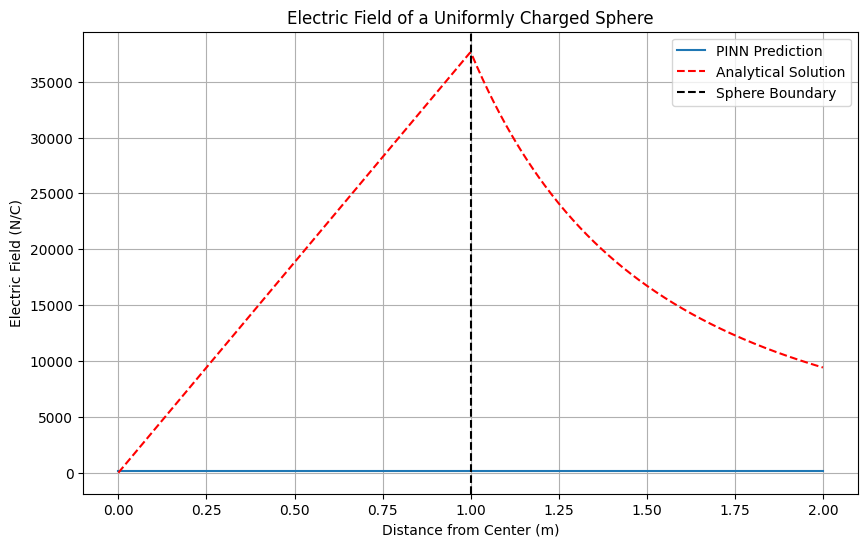

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Constants
epsilon_0 = 8.85e-12  # Permittivity of free space (F/m)
rho = 1e-6  # Uniform charge density (C/m^3)
R = 1.0  # Radius of the sphere (m)

# Define the neural network
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(1, activation='linear')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

# Define the loss function
def loss_fn(model, x, inside):
    with tf.GradientTape() as tape:
        tape.watch(x)
        E_pred = model(x)
        E_pred = tf.reshape(E_pred, [-1])

    dE_dx = tape.gradient(E_pred, x)

    r = tf.reshape(x, [-1])

    # Calculate the analytical solution for the electric field
    E_true = tf.where(r < R, (rho * r) / (3 * epsilon_0), (rho * R**3) / (3 * epsilon_0 * r**2))

    # Calculate the loss as the mean squared error between the predicted and true electric fields
    loss = tf.reduce_mean(tf.square(E_pred - E_true))

    return loss

# Generate training data
r_inside = np.random.uniform(0, R, 1000).reshape(-1, 1).astype(np.float32)
r_outside = np.random.uniform(R, 2*R, 1000).reshape(-1, 1).astype(np.float32)
r_train = np.vstack([r_inside, r_outside]).astype(np.float32)

# Convert training data to tensors
r_train_tensor = tf.convert_to_tensor(r_train)

# Create the model and optimizer
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
epochs = 5000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, r_train_tensor, True)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 500 == 0:
        print(f'Epoch {epoch}: Loss = {loss.numpy()}')

# Test the model
r_test = np.linspace(0, 2*R, 500).reshape(-1, 1).astype(np.float32)
r_test_tensor = tf.convert_to_tensor(r_test)
E_pred = model(r_test_tensor)

# Analytical solution
r_test_np = r_test.flatten()
E_true = np.where(r_test_np < R, (rho * r_test_np) / (3 * epsilon_0), (rho * R**3) / (3 * epsilon_0 * r_test_np**2))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(r_test, E_pred, label='PINN Prediction')
plt.plot(r_test, E_true, 'r--', label='Analytical Solution')
plt.axvline(R, color='k', linestyle='--', label='Sphere Boundary')
plt.xlabel('Distance from Center (m)')
plt.ylabel('Electric Field (N/C)')
plt.title('Electric Field of a Uniformly Charged Sphere')
plt.legend()
plt.grid(True)
plt.show()
